# TODO

- [ ] Description of Repository
- [ ] Power Exercises
    - [X] instrumentation
    - [X] Run power measurements
    - [ ] power modelling
- [X] Add polybench apps
- [ ] Build an measure also polybench

In [1]:
%%html
<style>
.container { width:100% !important; }
.rendered_html pre code {border: 0; background-color: #f4f4f4; display:inline-block;}
.rendered_html code.language-cpp {border: 0; background-color: #f4f4f4; display:inline-block;}
</style>

# Task 1.1 - Implement Time Measurements and Instrumentation

1. Edit [`benchmarks/time_instrumentation/common/instrumentation.h`](/edit/benchmarks/time_instrumentation/common/instrumentation.h) (you can click on the link to edit the file)
    * Use `gettimeofday` to measure time. Here en example on how to use it:
```cpp
struct timeval mytime;
gettimeofday(&mytime, NULL);
unsigned long time1 = (unsigned long)mytime.tv_sec * 1e6 + (unsigned long)mytime.tv_usec;
/* Some other code */
unsigned long time2 = (unsigned long)mytime.tv_sec * 1e6 + (unsigned long)mytime.tv_usec;
unsigned long diff = time2 - time1;
```
    * make sure the kernel finished before measuring time after kernel launch
2. Insert `PRE_KERNEL` and `POST_KERNEL` before and after each kernel launch in the [benchmarks](tree/benchmarks/time_instrumentation).  
   Example:
```cpp
PRE_KERNEL
vectorAdd<<<grid_size,block_size>>>(A,B,C);
POST_KERNEL
```
3. Compile the benchmarks in cuda_flux and time_instrumentation after completing the tasks.

In [2]:
%%bash
module load cuda llvm cuda-flux 
cd benchmarks/time_instrumentation && make

cd kmeans && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
cd 5p-stencil && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/5p-stencil'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/5p-stencil'


# Task 1.2 - Build power instrumentation binaries

View [`benchmarks/power_instrumentation/common/instrumentation.h`](/edit/benchmarks/power_instrumentation/common/instrumentation.h) you need to define the PRE_KERNEL and POST_KERNEL macros in line XX and YY. Multiple lines can be defined like this:

```cpp
#define MYMACRO std::cout << "Hello "; \
                std::cout << "World!\n"; \
                std::cout << "Good bye\n";
```

When measuring power the kernel should be executed in a loop until a time threshold is reached. One second usually works fine. To check if the time is really up the kernel must be finished after each iteration ( use cudaDeviceSynchronize(); *hint hint*).

A loop which will be executet until at least one second is reached could be implemented like this:

```cpp
for (auto start = std::chrono::steady_clock::now(),
     nvml_now = start; nvml_now < start + std::chrono::milliseconds{1000};
     nvml_now = std::chrono::steady_clock::now()) {
    /* loop body */
}
```

# Task 1.3- Add additional workloads for the benchmarks

1. Edit [measurements/my_benchmarks/app_arguments.txt](/edit/measurements/my_benchmarks/app_arguments.txt) and add more workloads
    Syntax is as follows:
    ```
    <executable> <workload name> <arguments>
    ```
    Example
    ```
    n-body 1k-bodies 1024
    n-body 2k-bodies 2048
    ```
2. Update [measurements/benchmarks_lists/my_benchmarks.yaml](/edit/measurements/benchmark_lists/my_benchmarks.yaml). Add the workload names you created for each benchmark. 
    The result could look like this: 
    ```
    n-body [1k-bodies, 2k-bodies]
    ```
    * Try to use at least four different workloads for each application.
    * Test how large the workload can be, without running out of memory on the GPU.
    * The largest pre-defined workload should fit within 4GB.

# Task 1.4 - Execute the Benchmarks

1. Execute `prepare_measurements.sh`. It will copy the binaries to the benchmark folder

In [4]:
%%bash
module load cuda llvm cuda-flux
./prepare_measurements.sh

building cuda flux binaries..
cd kmeans && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/kmeans'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/kmeans'
cd 5p-stencil && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/5p-stencil'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/5p-stencil'
building time instrumentation binaries..
cd kmeans && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
cd 5p-stencil && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/5p-stencil'
make[1]: Nothing to be done for 

2. Go to the measurements folder and create scripts for your measurements:

In [5]:
%%bash
# TODO make sure scripts are executable (no python3 needed)
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b time -t time_K80 -i 10 -q 'srun --partition=K80' > time_measurements_K80.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b time -t time_T4 -i 10 -q 'srun --partition=T4' > time_measurements_T4.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b power -t power_K80 -i 10 -q 'srun --partition=K80' > power_measurements_K80.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b power -t power_T4 -i 10 -q 'srun --partition=T4' > power_measurements_T4.sh

# Create script measuring kernel metrics on any GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'flux' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b flux -t flux -i 1 -q 'srun' > cuda_flux_measurements.sh

echo Created benchmark scripts:
ls *_measurements*.sh

Created benchmark scripts:
cuda_flux_measurements.sh
time_measurements_K80.sh
time_measurements_T4.sh


./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))


3. Execute the generated scripts.

In [6]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run cuda flux measurements on any GPU
bash cuda_flux_measurements.sh

Process is terminated.


**Please run time and power measuring only on either the K80 or the T4 GPU.**  
There is only an limited number of GPUs available and running the measurement on both GPU will take much more time to finish for everyone.

In [20]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run time measurements on a T4 GPU
bash time_measurements_T4.sh
# Run time measurements on a T4 GPU
#bash time_measurements_K80.sh

Process is terminated.


In [6]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run power measurements on a T4 GPU
bash power_measurements_T4.sh
# Run power measurements on a T4 GPU
#bash power_measurements_K80.sh

Process is terminated.


# Task 2.1- Process the Measurement Results

Stay in the folder measurements and process the measurement results:

In [7]:
%%bash
# TODO make sure scripts are executable (no python3 needed)
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements
rm -f cuda_flux_metrics.db kernel_time_K80.db kernel_time_T4.db
python3 processing/extractCUDAFluxMetrics.py -logdir log -tag flux -o cuda_flux_metrics.db
#python3 processing/extractKernelTime.py -logdir log -tag time_K80 -o kernel_time_K80.db
python3 processing/extractKernelTime.py -logdir log -tag time_T4 -o kernel_time_T4.db

Namespace(logdir='log', o='cuda_flux_metrics.db', tag='flux')
Processing my_benchmarks 5p-stencil s5
('log/4108/20201209-112716.272422_p2x02_5p-stencil',)
Processing my_benchmarks 5p-stencil_opt s5
('log/7bc8/20201209-112738.397100_p2x02_5p-stencil_opt',)
Processing my_benchmarks kmeans s1
('log/6d44/20201209-112754.667880_p2x02_kmeans',)
Processing my_benchmarks 5p-stencil s1
('log/3e10/20201209-112713.278634_p2x02_5p-stencil',)
Processing my_benchmarks kmeans s5
('log/c29e/20201209-112757.648638_p2x02_kmeans',)
Processing my_benchmarks 5p-stencil_opt s1
('log/120b/20201209-112735.391651_p2x02_5p-stencil_opt',)
Done
using tag  time_T4
('log/e4f0/20210114-112936.614234_g4dn01_5p-stencil_opt',)
('log/cf76/20210114-112948.129147_g4dn01_5p-stencil_opt',)
('log/4e89/20210114-112959.500749_g4dn01_5p-stencil_opt',)
('log/e63f/20210114-113010.849196_g4dn01_5p-stencil_opt',)
('log/57c7/20210114-113022.214632_g4dn01_5p-stencil_opt',)
('log/36d2/20210114-113033.589559_g4dn01_5p-stencil_opt',)
('

processing/extractCUDAFluxMetrics.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(filepath, 'r'))


You may inspect the results using pandas reading the sqlite database.

You can view how data is stored in the database using sqlite3:

In [8]:
%%bash
sqlite3 measurements/cuda_flux_metrics.db .schema

CREATE TABLE fluxmetrics
                    (bench text not null,
                    app text not null,
                    dataset text not null,
                    lseq integer not null,
                    name text not null,
                    metric text not null,
                    value double not null);


In [9]:
import pandas as pd
import sqlite3

with sqlite3.Connection('measurements/cuda_flux_metrics.db') as conn:
        df_features = pd.read_sql_query("select * from fluxmetrics", conn)
        
df_features

,bench,app,dataset,lseq,name,metric,value
0,my_benchmarks,5p-stencil,s5,0,_Z20simpleStencil_KerneliPfS_,gX,163.0
1,my_benchmarks,5p-stencil,s5,0,_Z20simpleStencil_KerneliPfS_,gY,1.0
2,my_benchmarks,5p-stencil,s5,0,_Z20simpleStencil_KerneliPfS_,gZ,1.0
3,my_benchmarks,5p-stencil,s5,0,_Z20simpleStencil_KerneliPfS_,bX,128.0
4,my_benchmarks,5p-stencil,s5,0,_Z20simpleStencil_KerneliPfS_,bY,1.0
...,...,...,...,...,...,...,...
363,my_benchmarks,5p-stencil_opt,s1,0,_Z17optStencil_KerneliPfS_,setp.gt.f32,1044484.0
364,my_benchmarks,5p-stencil_opt,s1,0,_Z17optStencil_KerneliPfS_,selp.f32,2088968.0
365,my_benchmarks,5p-stencil_opt,s1,0,_Z17optStencil_KerneliPfS_,setp.lt.f32,1044484.0
366,my_benchmarks,5p-stencil_opt,s1,0,_Z17optStencil_KerneliPfS_,st.global.f32,1044484.0


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

with sqlite3.Connection('measurements/kernel_time_K20.db') as conn:
            df_time = pd.read_sql_query("select * from kerneltime", conn)
        
df_time

,bench,app,dataset,build,lseq,time
0,my_benchmarks,mvt,s4,time,0,547376
1,my_benchmarks,mvt,s4,time,1,59288
2,my_benchmarks,mvt,s4,time,0,538874
3,my_benchmarks,mvt,s4,time,1,59236
4,my_benchmarks,mvt,s4,time,0,539623
...,...,...,...,...,...,...
115,my_benchmarks,mvt,s1,time,1,2114
116,my_benchmarks,mvt,s1,time,0,7287
117,my_benchmarks,mvt,s1,time,1,2108
118,my_benchmarks,mvt,s1,time,0,7272


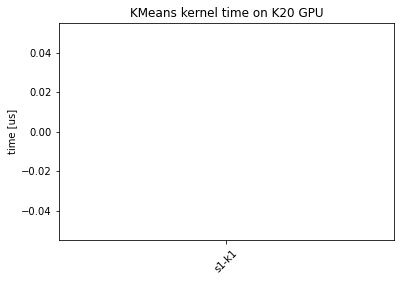

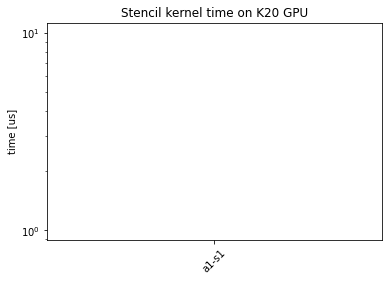

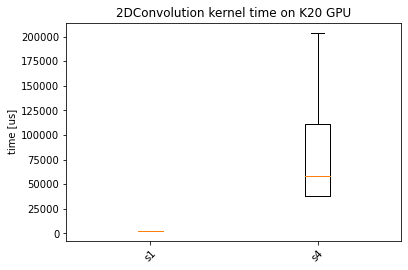

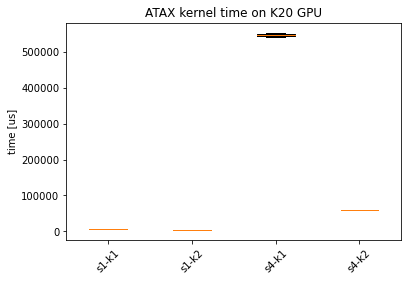

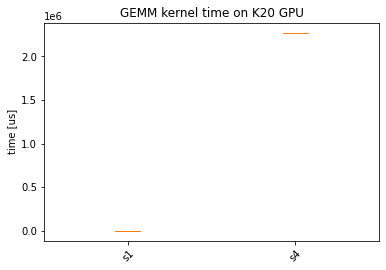

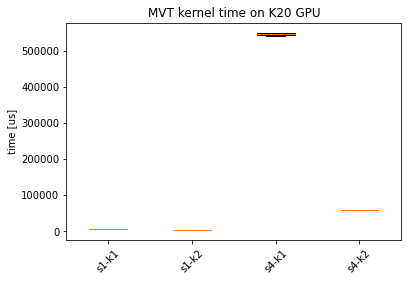

In [2]:
kernel_time = df_time

data_stencil = []
data_kmeans = []
data_2dconv = []
data_atax = []
data_gemm = []
data_mvt = []
for idx,values in kernel_time.groupby(['bench','app','dataset','lseq'])['time']:
    if idx[1].startswith('5p-stencil'):
        data_stencil.append(values)
    elif idx[1].startswith('kmeans'):
        data_kmeans.append(values)
    elif idx[1].startswith('2DConvolution'):
        data_2dconv.append(values)
    elif idx[1].startswith('atax'):
        data_atax.append(values)
    elif idx[1].startswith('gemm'):
        data_gemm.append(values)
    else:
        data_mvt.append(values)
    
# KMeans Plot
xlabels = []
#for dataset in ['s1', 's2', 's3', 's4', 's5']:
for dataset in ['s1', 's5']:    
    for kernel in ['k1', 'k2', 'k3']:
        xlabels.append(dataset + '-' + kernel)
        
fig1, ax1 = plt.subplots()
#ax1.set_yscale('log')

ax1.set_title('KMeans kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_kmeans, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)
plt.savefig('kmeans_time.pdf')

# Stencil Plot
xlabels = []
for app in ['a1', 'a2']:
#    for dataset in ['s1', 's2', 's3', 's4', 's5']:
    for dataset in ['s1', 's5']:
        xlabels.append(app + '-' + dataset)
        
fig1, ax1 = plt.subplots()
ax1.set_yscale('log')

ax1.set_title('Stencil kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_stencil, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)
#plt.savefig('stencil_time.pdf')

# 2DConvolution Plot
# xlabels = []
# for dataset in ['s1', 's4']:
#     xlabels.append(dataset)
xlabels = ['s1', 's4']
        
fig1, ax1 = plt.subplots()
#ax1.set_yscale('log')

ax1.set_title('2DConvolution kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_2dconv, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)

# ATAX Plot
xlabels = []
for dataset in ['s1', 's4']:    
    for kernel in ['k1', 'k2']:
        xlabels.append(dataset + '-' + kernel)
        
fig1, ax1 = plt.subplots()
#ax1.set_yscale('log')

ax1.set_title('ATAX kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_atax, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)

# GEMM Plot
xlabels = ['s1', 's4']
        
fig1, ax1 = plt.subplots()
#ax1.set_yscale('log')

ax1.set_title('GEMM kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_gemm, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)

# MVT Plot
xlabels = []
#for dataset in ['s1', 's2', 's3', 's4', 's5']:
for dataset in ['s1', 's4']:    
    for kernel in ['k1', 'k2']:
        xlabels.append(dataset + '-' + kernel)
        
fig1, ax1 = plt.subplots()
#ax1.set_yscale('log')

ax1.set_title('MVT kernel time on K20 GPU')
ax1.set_ylabel('time [us]')
res = ax1.boxplot(data_mvt, showfliers=False)
ax1.set_xticklabels(xlabels)
ax1.xaxis.set_tick_params(rotation=45)

# Coffee Break ☕

# Task 2.2 - Use GPU Mangrove to make predictions
    
**1. Execute `init_gpu_mangrove.sh` and go to the gpu mangrove folder**

In [11]:
%%bash
./init_gpu_mangrove.sh

fatal: destination path 'gpu-mangrove' already exists and is not an empty directory.


**2. Convert the CUDA Flux metrics:**

In [13]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
rm -f my_model_features.db
./mangrove.py convert -i ../measurements/cuda_flux_metrics.db -o my_model_features.db

Processing Items..


100%|██████████| 30/30 [00:00<00:00, 849.89it/s]


**3. Process the features:**

In [15]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
rm -f data/my_ML_samples_T4.db
./mangrove.py process --fdb my_model_features.db --mdb ../measurements/kernel_time_T4.db -o data/my_ML_samples_T4.db

Processing DBs
Empty DataFrame
Columns: [bench, app, dataset, name]
Index: []


Inspect the sample database.

In [2]:
import pandas as pd
import sqlite3

with sqlite3.Connection('gpu-mangrove/data/my_ML_samples_T4.db') as conn:
            df = pd.read_sql_query("select * from samples", conn)
        
df

,index,bench,app,dataset,name,threads_per_CTA,CTAs,total_instructions,special_operations,logic_operations,control_operations,arithmetic_operations,sync_operations,global_memory_volume,param_memory_volume,shared_memory_volume,arithmetic_intensity,time
0,0,my_benchmarks,5p-stencil,s1,_Z20simpleStencil_KerneliPfS_,128.0,9.0,2.721541e+08,0.0,8.778532e+06,8.780836e+06,2.019201e+08,0.0,2.106848e+08,23040.0,0.000000e+00,0.958294,5441.0
1,1,my_benchmarks,5p-stencil,s5,_Z20simpleStencil_KerneliPfS_,128.0,163.0,9.320321e+11,0.0,3.006554e+10,3.006558e+10,6.915077e+11,0.0,7.215730e+11,417280.0,0.000000e+00,0.958333,2930504.0
2,2,my_benchmarks,5p-stencil_opt,s1,_Z17optStencil_KerneliPfS_,128.0,9.0,5.682289e+07,0.0,5.283080e+06,4.239635e+06,3.571036e+07,2127872.0,8.433680e+06,21232.0,2.096749e+07,4.223623,1021.0
3,3,my_benchmarks,5p-stencil_opt,s5,_Z17optStencil_KerneliPfS_,128.0,163.0,2.277936e+10,0.0,2.116875e+09,1.697547e+09,1.431856e+10,852090880.0,3.381576e+09,416304.0,8.413758e+09,4.233765,580893.0
4,4,my_benchmarks,kmeans,s1,_Z19kmeans_centroid_sumPfPiS_S0_iii,1024.0,1.0,1.015770e+05,0.0,1.042000e+03,1.898000e+04,6.105700e+04,1024.0,1.232400e+04,28744.0,4.505600e+04,1.486729,40.0
5,5,my_benchmarks,kmeans,s1,_Z22kmeans_centroid_updatePfPiii,6.0,1.0,1.440000e+02,0.0,0.000000e+00,1.200000e+01,9.000000e+01,0.0,7.200000e+01,144.0,0.000000e+00,0.416667,9.0
6,6,my_benchmarks,kmeans,s1,_Z25kmeans_cluster_assignmentPfPiS_iii,1024.0,1.0,1.484800e+05,3072.0,2.048000e+03,2.764800e+04,9.625600e+04,0.0,5.324800e+04,36864.0,0.000000e+00,1.068182,22.0
7,7,my_benchmarks,kmeans,s5,_Z19kmeans_centroid_sumPfPiS_S0_iii,1024.0,60.0,6.094620e+06,0.0,6.252000e+04,1.138800e+06,3.663420e+06,61440.0,7.394400e+05,1724640.0,2.703360e+06,1.486729,72.0
8,8,my_benchmarks,kmeans,s5,_Z22kmeans_centroid_updatePfPiii,6.0,60.0,8.640000e+03,0.0,0.000000e+00,7.200000e+02,5.400000e+03,0.0,4.320000e+03,8640.0,0.000000e+00,0.416667,10.5
9,9,my_benchmarks,kmeans,s5,_Z25kmeans_cluster_assignmentPfPiS_iii,1024.0,60.0,8.908800e+06,184320.0,1.228800e+05,1.658880e+06,5.775360e+06,0.0,3.194880e+06,2211840.0,0.000000e+00,1.068182,26.0


**4. Make predictions using a pre-trained model**

In [13]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
./mangrove.py predict -i data/my_ML_samples_T4.db -m data/pre_trained/time_model_T4_median_100.pkl -o results.pkl

Index(['threads_per_CTA', 'CTAs', 'total_instructions', 'special_operations',
       'logic_operations', 'control_operations', 'arithmetic_operations',
       'sync_operations', 'global_memory_volume', 'param_memory_volume',
       'shared_memory_volume', 'arithmetic_intensity'],
      dtype='object')
Results:
                                                                                y_true        y_pred  pred/true
bench         app            dataset name                                                                      
my_benchmarks 5p-stencil     s1      _Z20simpleStencil_KerneliPfS_              5441.0   1172.548318   0.215502
                             s5      _Z20simpleStencil_KerneliPfS_           2930504.0  53536.509107   0.018269
              5p-stencil_opt s1      _Z17optStencil_KerneliPfS_                 1021.0    409.008239   0.400596
                             s5      _Z17optStencil_KerneliPfS_               580893.0   5078.921169   0.008743
              km

/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TransformedTargetRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid 

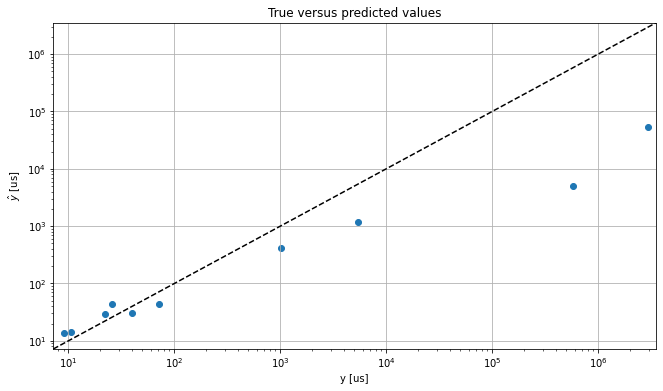

In [19]:
import pickle

results = pickle.load(open('gpu-mangrove/results.pkl', 'rb'))
#results.plot.scatter(x='y_true', y='y_pred')
fig, ax1 = plt.subplots(1,1,figsize=(10.8,6))

guide_min = results['y_true'].min()*0.8
guide_max = results['y_true'].max()*1.2
ax1.scatter(results['y_true'], results['y_pred'])
ax1.plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
ax1.set_xlabel('y [us]')
ax1.set_ylabel(r'$\^y$ [us]')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([guide_min,guide_max])
ax1.set_xlim([guide_min,guide_max])
ax1.set_title("True versus predicted values")
ax1.grid()

# Task 2.3 - Create and Evaluate Simple ML Model

1. Complete [simple_model.py](/edit/simple_model.py). Select parameters for your learning algorithm. You may use other regressors than random forest.
    * https://scikit-learn.org/stable/modules/svm.html#regression
    * https://scikit-learn.org/stable/modules/ensemble.html
2. Use the any sample datebase you want for this task. The  `simple_model.py` script expects the first argument to be the database.
```
./simple_model.py gpu-mangrove/data/my_ML_samples_T4.db
```
3. Examine model parameter and test scores

# Task 2.4 [optional] - Create ML Model using GPU Mangrove dataset

Take `simple_model.py` as a template and develop a more sophisticated ML Model
* Test different sets of hyper-parameters. Cross-validation can be helpful.  
  https://scikit-learn.org/stable/modules/grid_search.html
* The quality of the prediction can be measured using different error metrics. Which metrics help best to understand the quality of the predictions?